##### This script will associate spoken phrases with their corresponding translation, using Dynamic Time Warping (DTW) algorithm on MFCC of audio recordings. This example will rely on 10 phrases I recorded myself saying 10 times each.

## Dynamic Time Warping (DTW)

One of the challenges inherent in speech recognition is that the tenor of speech can vary, and this is particularly true for dysarthric speech, where imprecision is the result of disruption of muscular control. Although a dysarthric speaker will typically make consistent errors or distortions (which is why we are focusing on dysarthria rather than apraxia) they have difficulty with the speed of articulation, or with phoneme transitions, and the same phrase spoken by the same speaker may vary in length.

We could use Euclidian distance to compare the similarity of two signals of the same duration, but if we want to compare signals of different duration, we need to transform one of them. DTW is an algorithm that allows for a non-linear transformation of the time series, either compressing or stretching it, so that the distance between the two signals is minimized (ie the optimal alignment is achieved taking into account temporal distortions such as pauses or changes in speed).


![](DTW.png)

<sup>_image from E Keough, Dept of CS, UC Riverside_</sup>

By applying DTW, we can compare an input phrase to a dictionary of labeled phrases of different durations, and compare the minimized distances to determine which labeled phrase most closely matches the input.

## 1) Load Packages

In [1]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

# import matplotlib.pylab as plt
from skimage import data, img_as_float
from skimage import exposure
import sklearn
import random
import itertools
import librosa
import librosa.display
import IPython.display as ipd

%matplotlib inline

## 2) Load Data and Compute MFCCs

In [2]:
prompt_master = pd.read_csv('../data/recorded/recorded_prompts.txt', sep="|", 
                      header=None, names=['prompt_id','prompt'])

prompt_master.head()
num_classes = len(prompt_master['prompt']) 
print('Unique prompts:', num_classes)

Unique prompts: 10


In [3]:
# LOAD 1 RECORD IN TRAINING AND 9 RECORDS IN TEST FOR EACH PROMPT
mfcc = []
prompts = []
prompt_text = []
train = []

for p in range(1,11):
    print(prompt_master['prompt'][p-1])
    for i in range(1,11):
        aud_loc = '../data/recorded/' + str(p) + '_' + str(i) + '.wav'
        #print(aud_loc)
                
        data, rate = librosa.load(aud_loc)
        
#         # Trim leading and trailing silence
# 
#         len_pre = librosa.get_duration(data) * 100.000
#         data, index = librosa.effects.trim(data, frame_length=40, hop_length=10)
#         print('Amount trim: ', len_pre - (librosa.get_duration(data) * 100.000))
        
#         #Add white noise
        
#         wn = np.random.randn(len(data))
#         data = data + 0.005*wn
        
        mfcc.append(librosa.feature.mfcc(data, rate))
        
        prompts.append(p-1)
        prompt_text.append(prompt_master['prompt'][p-1])
        
        train.append(1 if i <= 1 else -1)

what day is today
how are you
i am hungry
i need to go to the bathroom
i am tired
i am happy
i am sad
the quick brown fox jumped over the lazy dog
i want to go for a walk
please turn on the tv


In [4]:
# Scale features
for i,x in enumerate(mfcc): 

    mfcc[i] = sklearn.preprocessing.scale(mfcc[i], axis=1)
    
print(mfcc[0].shape)    

(20, 78)


{0: 'what day is today', 1: 'how are you', 2: 'i am hungry', 3: 'i need to go to the bathroom', 4: 'i am tired', 5: 'i am happy', 6: 'i am sad', 7: 'the quick brown fox jumped over the lazy dog', 8: 'i want to go for a walk', 9: 'please turn on the tv'}


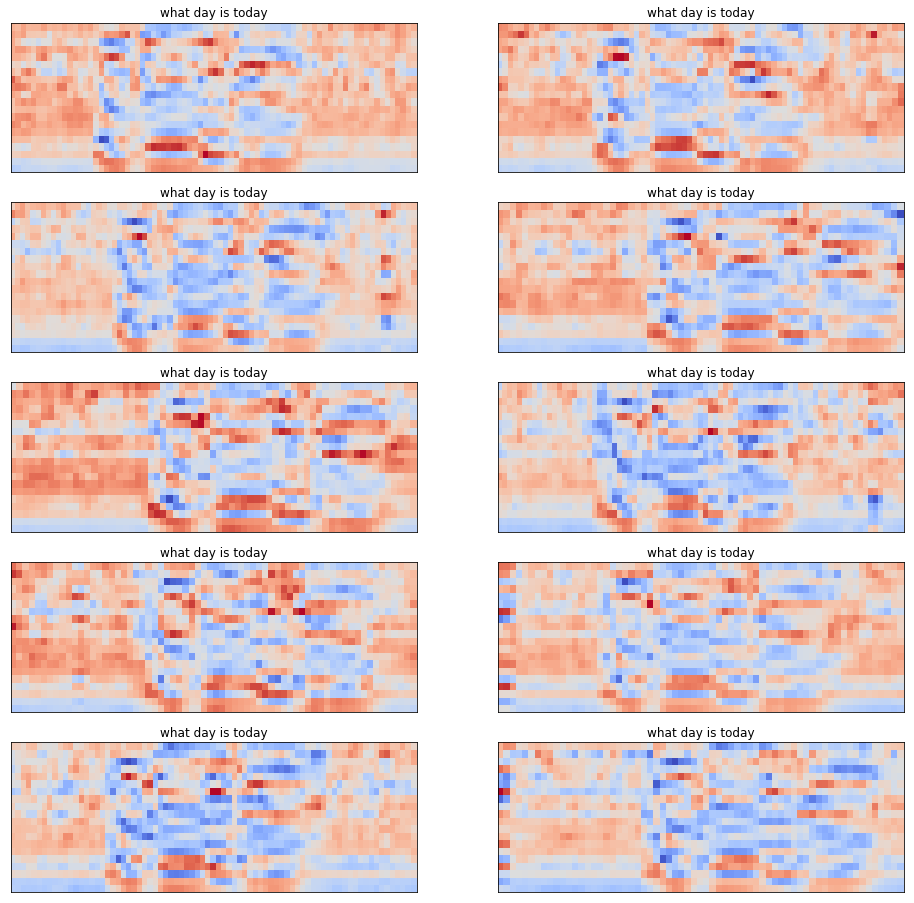

In [6]:
cat = dict(zip(prompts, prompt_text))  # Dictionary to look up prompt text from prompt code
num_examples = 10

fig = plt.figure(figsize=(16, 16))

for i in range(num_examples):
    plt.subplot(5,2,i+1)
    librosa.display.specshow(mfcc[i])
    plt.title(cat.get(prompts[i]))
    
print(cat)

## 3) Compare using DTW

In [7]:
from scipy.spatial.distance import euclidean
from numpy.linalg import norm
from fastdtw import fastdtw

In [8]:
x_train = [mfcc[i] for i,x in enumerate(train) if x==1]
y_train = [prompts[i] for i,x in enumerate(train) if x==1]
x_test = [mfcc[i] for i,x in enumerate(train) if x==-1]
y_test = [prompts[i] for i,x in enumerate(train) if x==-1]
print('# train: ', len(y_train))
print('# test: ', len(y_test))

# train:  10
# test:  90


In [9]:
x_test[0].shape

(20, 77)

In [23]:
# View an example MFCC before and after shifting
x_train[0]

array([[-1.36646934, -1.27939212, -1.01104749, ..., -0.82547355,
        -0.75483886, -0.76755365],
       [-0.94797059, -0.89962896, -1.0079711 , ..., -0.7476764 ,
        -0.70500161, -0.65557164],
       [ 0.05098807,  0.08968127,  0.33226643, ...,  0.02102205,
        -0.00428957,  0.27277619],
       ...,
       [ 0.90767316,  0.36110543, -0.42009901, ...,  0.74676901,
         0.07963511, -0.24816833],
       [ 1.03870333,  0.82354279,  1.07876935, ...,  1.07210849,
         0.57753492,  0.25550851],
       [ 0.7429699 ,  0.59492667,  1.02800308, ...,  1.0285529 ,
         0.54811577,  0.78235782]])

In [24]:
# Use np.roll before transposing. It shifts each row (MFCC vector) left or right
np.roll(x_train[0],1)

array([[ 0.78235782, -1.36646934, -1.27939212, ..., -0.96733066,
        -0.82547355, -0.75483886],
       [-0.76755365, -0.94797059, -0.89962896, ..., -0.75578827,
        -0.7476764 , -0.70500161],
       [-0.65557164,  0.05098807,  0.08968127, ...,  0.08123861,
         0.02102205, -0.00428957],
       ...,
       [ 0.03219034,  0.90767316,  0.36110543, ...,  1.12301261,
         0.74676901,  0.07963511],
       [-0.24816833,  1.03870333,  0.82354279, ...,  1.34961218,
         1.07210849,  0.57753492],
       [ 0.25550851,  0.7429699 ,  0.59492667, ...,  1.35739961,
         1.0285529 ,  0.54811577]])

In [25]:
# CALCULATE DTW DISTANCE

# Create list of length 90 for each test record
# In that list, each element will be a 31 x 10 matrix with the distance to each of the 10 training records 
# (for each of the -/+ 15 shifts shifting the test MFCC vector left or right)

print(datetime.datetime.now())

master_dist = []
for i,x in enumerate(x_test):
    mfcc_dist = []
    # For each shift -/+ 15
    for d in range(-15, 16):
        dist = []
        for i2,x2 in enumerate(x_train):
            distance, path = fastdtw(np.roll(x,d).T, x2.T, dist=lambda x, y: norm(x - y))
            dist.append(distance)
        mfcc_dist.append(dist)
    master_dist.append(mfcc_dist)
    
print(datetime.datetime.now())

In [31]:
# This is what each element looks like. There are 90 of these, 1 for each test record
# Each row corresponds to a different shift. The first row represents the MFCC test record shifted 15 to the left
# Each column represents the DTW distance of that MFCC test record to each training record 
# (since 10 phrases, there are 10 columns)
pd.DataFrame(master_dist[3])

# There are two approaches to determine the best matching training record to the test record
# 1) Find the best match from each row, then pick the match that was the best the most
# 2) OR of all 310 distances, pick the overall best match. --> This approach works the best! 

,0,1,2,3,4,5,6,7,8,9
0,357.629353,381.633086,347.546139,379.870363,311.849744,357.443728,290.038373,620.600623,358.674241,415.768148
1,364.742420,371.256387,344.773917,376.216068,311.203300,339.007904,287.048831,602.435824,354.904381,411.216316
2,295.854580,367.458412,345.052849,368.622581,308.060405,334.936487,285.867191,600.404020,351.310888,410.750433
3,258.651704,363.982432,346.225115,367.441082,306.357672,347.557377,278.286579,608.117673,350.274602,410.133895
4,253.539765,361.477602,350.208155,369.855663,305.403863,341.791315,272.941764,643.040538,352.403096,410.498324
5,255.742032,364.182973,351.662957,377.560236,304.564500,334.460673,264.923448,644.979311,347.769827,411.743800
6,258.046646,328.599447,353.820942,351.050023,310.293100,332.846890,262.394049,623.755116,345.190152,414.794202
7,260.420485,343.965378,353.697381,347.307688,315.585139,330.928645,259.013393,624.047666,343.212350,415.880461
8,264.033861,334.585564,351.046126,343.723056,319.399488,329.017582,258.955814,592.202926,340.172144,416.724104
9,263.325923,322.250080,355.847531,339.979978,313.851847,327.385526,296.731637,622.054037,337.214362,406.621380


In [28]:
# DETERMINE PREDICTIONS

prediction = []
prediction_overalldist = []
votes = []

# Loop through each training example
for i,x in enumerate(master_dist):
    vote = []
    # For each of the 31 shift vectors, get the prediction with min distance - the votes
    min_dist = 1000000
    for i2,x2 in enumerate(x):
        vote.append(x2.index(min(x2)))
        
        # Save the overall min distance from all 31 vectors = overall closest prediction
        if min(x2) < min_dist:
            min_dist = min(x2)
            min_overall = x2.index(min(x2))
        
    # Get the most common prediction out of the 31 MFCC vectors - the final vote
    prediction.append(max(set(vote), key=vote.count))
    # Overall closest prediction out of the 31 MFCC vectors - the final vote
    prediction_overalldist.append(min_overall)
    
    # Track votes - determine if some vectors perform worse
    votes.append(vote)

In [29]:
num_correct = 0
num_correct_overall = 0

print('----------------------------------------------------------------------')
print('Correct|Prediction Vote|Prediction Overall|MFCC Predictions')
for i,x in enumerate(votes):
    print(y_test[i], '|', prediction[i], '|', prediction_overalldist[i], x)
    if y_test[i] == prediction[i]: num_correct += 1
    if y_test[i] == prediction_overalldist[i]: num_correct_overall += 1
print('----------------------------------------------------------------------')    
print('% Correct (Vote):', num_correct / 90.0 * 100)
print('% Correct (Overall):', num_correct_overall / 90.0 * 100)

----------------------------------------------------------------------
Correct|Prediction Vote|Prediction Overall|MFCC Predictions
0 | 0 | 0 [4, 4, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6]
0 | 0 | 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6]
0 | 1 | 0 [6, 6, 0, 0, 6, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 5]
0 | 1 | 0 [6, 6, 6, 0, 0, 0, 0, 6, 6, 0, 6, 0, 0, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0 | 0 | 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6]
0 | 1 | 0 [6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 5, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0 | 0 | 0 [0, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
0 | 0 | 0 [0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 2, 5, 5, 5, 0, 6, 6, 6]
0 | 1 | 0 [6, 0, 0, 0, 0, 0, 0, 0, 0,

##### Results (1 train and 9 test records): 

1) 92% accuracy using the best of 31 vote (-/+ 15 shifts)

2) 100% accuracy using the overall min distance from the (-/+ 15 shifts)  --> This is the approach we should use!

##### Notes

We are able to obtain 100% accuracy. Our final model should involve trimming silence at the begining and end of each recording, even though we did not need it for these recordings. We want our model to work if people start recording and then delay saying something, or say something and delay stopping the recording. (The code to do this is commented out in this workbook. I believe that code should work, but we should test) Also, this workbook used shifts of -/+ 15 for a total of 31 MFCC matrices for each test record. We may be able to speed things up by using a smaller shift range.

##### Next Steps

1) How does this work on phrases spoken by people with dysarthric speech
2) What happens as the number of training recordings increases (right now there are only 10 "saved" recordings, but what if there were 50?)